# TC Profiling


In [9]:
# global settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata
import numpy as np
import seaborn
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd


## NS / SFC / VNF Model

The first approach for a simplistic NS/ SFC / VNF performance model that can be used to play with different profiling approaches. As a first shot, the model tries to mimic the results from our NFV-SDN'17 paper [1]. The model focuses only on throughput as main metric for now. 

### Assumptions / Design

* A (network service) model instance consists of $n$ VNFs in a linear chain $f_1, ..., f_n$.
* Each VNF is represented by an arbitrary function $p_i$ that maps CPU-time to throughput: $p_i: c \rightarrow t_p$
* Each position in the chain has a scaling factor $\alpha$ assigned that influences the actual performance achieved by the VNF at that position. This models the changing performance behavior for changing VNF positions in the chain.
* These scaling factors are initialized with the model and might be randomized.
* The global (network service) throughput can be computed by giving a vector of CPU-times to the model: $(c_1, c_2, ... c_n)$ for $f_1, ..., f_n$
* The global (network service) throughput is computed as the minimum over all VNF throughputs combined with the positional scaling factor of their location: $min\{p_i(c_i)*\alpha_i\} \forall i \in [1, n]$.

### References

<small>
* [1] M. Peuster and H. Karl: Profile Your Chains, Not Functions: Automated Network Service Profiling in DevOps Environments. IEEE Conference on Network Function Virtualization and Software Defined Networks (NFV-SDN), Berlin, Germany. (2017) 
</small>

In [3]:
class NS(object):
    """
    A network service based on a linear SFC: f1 -> f2 -> ... -> fN 
    """
    
    def __init__(self, name, vnfs, alphas = None):
        """
        name: name of service (string)
        vnfs: vector of functions representing the VNF's CPU-time -> throughput mapping
        alphas: vector of floats to scale the performance of a VNF at the corresponding position (set to [1.0,...,1.0] if None)
        """
        self.name = name
        self.vnfs = vnfs
        self.alphas = alphas if alphas else [1.0 for _ in self.vnfs]
        print("Initialized '{}' with alphas={}".format(self.name, self.alphas))   
        
    def _calc_vnf_tp(self, cpu_times):
        """
        calculate TP for each function in self.vnfs
        cpu_times: CPU time available for each VNF
        """
        assert len(cpu_times) == len(self.vnfs) == len(self.alphas)
        # calculate result for each vnf and multiply by corresponding alpha
        return [f(r) * a for f, r, a in zip(self.vnfs, cpu_times, self.alphas)]
           
    def get_total_tp(self, cpu_times):
        """
        calculate TP of SFC
        cpu_times: CPU time available for each VNF
        """
        # uses "naive" minimum-TP model from NFV-SDN'17 paper for now
        return min(self._calc_vnf_tp(cpu_times))


In [4]:
#
# Model tests
#
# use simple linear models (based on NFV-SDN'17 paper results):
vnfs = [
    lambda x: 8.0 * x,  # nginx
    lambda x: 3.0 * x,  # socat
    lambda x: 1.2 * x   # squid
]

n1 = NS("n1", vnfs)
print(n1.get_total_tp([0.16, 0.16, 0.16]))
print(n1.get_total_tp([1.0, 1.0, 1.0]))
print(n1.get_total_tp([1.0, 1.0, 1.0]))

n2 = NS("n2", vnfs, alphas=[np.random.uniform(0.2, 5.0) for _ in vnfs])
print(n2.get_total_tp([0.16, 0.16, 0.16]))
print(n2.get_total_tp([1.0, 1.0, 1.0]))
print(n2.get_total_tp([1.0, 1.0, 1.0]))

Initialized 'n1' with alphas=[1.0, 1.0, 1.0]
0.192
1.2
1.2
Initialized 'n2' with alphas=[0.5821816252078479, 0.8589536336493873, 0.98697258023607]
0.18949873540532544
1.184367096283284
1.184367096283284


### Model Validation
Implements the experiment setup of our NFV-SDN'17 paper to check if the model produces outputs that look like the ones seen in our experiments.

Note: This is still very rough and does not fit perfectly. However the results roughly behave like the ones in our paper, so we use this for now (cf. the following plot with Fig. 4 of [1]).

#### Problems

* The positional scaling factors are uniformly distributed between 1.0 and 6.0 for now. This should be improved. Needs investigation of our measurement data. Maybe we find something that fits better.
    * Or simply switch to normal distribution with $\mu = 1.0$? 


Initialized 'NS_base' with alphas=[1.0, 1.0, 1.0]
Initialized 'NS_1' with alphas=[1.965126450894147, 1.9536596020272365, 5.975455480288541]
Initialized 'NS_2' with alphas=[1.965126450894147, 1.9536596020272365, 5.975455480288541]
Initialized 'NS_3' with alphas=[1.965126450894147, 1.9536596020272365, 5.975455480288541]
Generated 27 configs.


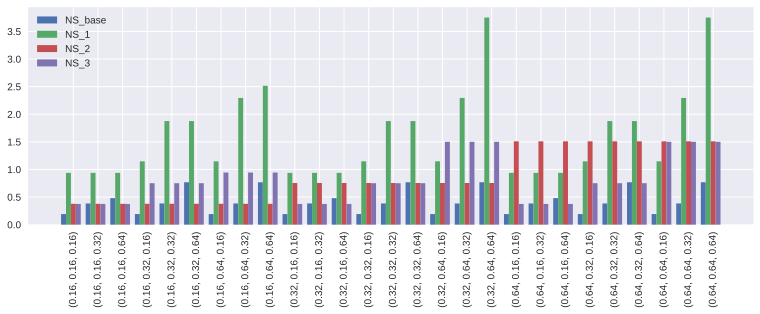

In [5]:
#
# Helper
#
def bar_plot_compare(configs, ns_list, ns_results):
    plt.figure(figsize=(13,4))
    X = np.arange(len(configs))
    bar_width = 1 / (len(ns_list) + 1)
    offset = 0
    for c, ns, r in zip(configs, ns_list, ns_results):
        plt.bar(X -(len(ns_list) / 2 * bar_width) + (bar_width * offset), r , width = bar_width, label=ns.name)
        offset += 1
    plt.xticks(X, configs, rotation=90)
    plt.legend()

def rotate(l, x):
    # permutate VNF list
    return l[-x:] + l[:-x]

#
# Model
#
# use simple linear models for VNFs (based on NFV-SDN'17 paper results):
vnfs = [
    lambda x: 8.0 * x,  # nginx
    lambda x: 3.0 * x,  # socat
    lambda x: 1.2 * x   # squid
]

# generate random alphas (NFV-SDN'17 paper shows variance up to 6.0x comp. to model)
alphas=[np.random.uniform(1.0, 6.0) for _ in vnfs]
#alphas=[abs(np.random.normal(1.0, 0.5)) for _ in vnfs]

# generate one service instance without any random effects
ns_list = list()
ns_base = NS("NS_base", vnfs.copy())
ns_list.append(ns_base)

# generate three service instances and rotate the order of the VNFs
# (scaling (alphas) for each position is random but fixed accross NS instances)
ns_1 = NS("NS_1", vnfs.copy(), alphas=alphas)
ns_list.append(ns_1)
ns_2 = NS("NS_2", rotate(vnfs.copy(), 1), alphas=alphas)
ns_list.append(ns_2)
ns_3 = NS("NS_3", rotate(vnfs.copy(), 2), alphas=alphas)
ns_list.append(ns_3)

# generate list with resource configurations to "profile"
configs = list()
for c1 in [0.16, 0.32, 0.64]:
    for c2 in [0.16, 0.32, 0.64]:
        for c3 in [0.16, 0.32, 0.64]:
            configs.append((c1, c2, c3))
print("Generated {} configs.".format(len(configs)))

# compute results
ns_results = list()
for ns in ns_list:
    ns_results.append([ns.get_total_tp(c) for c in configs])

# plot
bar_plot_compare(configs, ns_list, ns_results)

## 2D Example Playground

As a first example we use a NS with two VNFs (two resource configuration parameters) to implement the full workflow of a possible evaluation:

1. Create full configuration space $C_{full}$
2. Select subset of configuration space $C_{full}$ randomly: $C_{selected}$
3. Compute profiling results for entire $C_{full}$ using our model.
4. Compute profiling results for $C_{selected}$ using our model.
5. Use ML/regression techniques to compute full results from $C_{selected}$ (prdiction).
6. Compute error between predicted results based on $C_{selected}$ and real results based on $C_{full}$.

Two main points to improve results:

- Selection algorithm (or sampling algorithm)
- Prdiction algorithm

This workflow is almost the same as in the PANIC paper(s) [2] and [3]. However, they focus on simpler applications and don't consider NFC / chaining scenarios. TODO: Clearly state differences and improvements to [2] and [3].

### References

<small>
* [2] Giannakopoulos, Ioannis, et al. "PANIC: modeling application performance over virtualized resources." Cloud Engineering (IC2E), 2015 IEEE International Conference on. IEEE, 2015.
* [3] Giannakopoulos, Ioannis, Dimitrios Tsoumakos, and Nectarios Koziris. "A Decision Tree Based Approach Towards Adaptive Profiling of Cloud Applications." arXiv preprint arXiv:1704.02855 (2017).
</small>


Initialized 'NS_1' with alphas=[1.0, 1.0]
Generated 400 sampels.
Selected 20 sampels


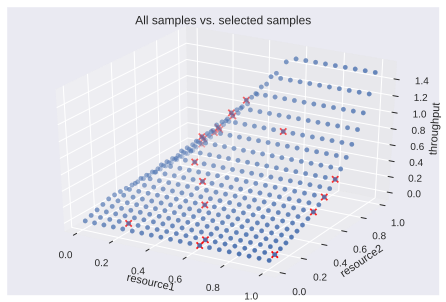

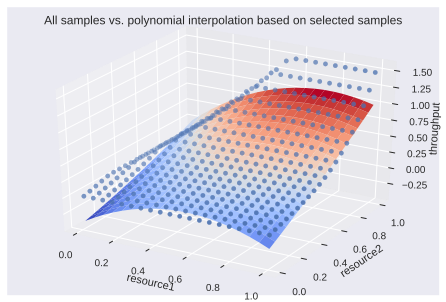

MAE (mean-absolute-error): 0.13252910487993927
MSE (mean-squared-error): 0.026496078095475734


In [31]:
#
# Playground with 2D (2 config parameter) example
#

#
# Helper / Plotting
#
def plot_two_3d_results(xy_1, z_1, xy_2, z_2, surface_2=False, title="the_title"):
    fig = plt.figure()
    ax = Axes3D(fig)
    # extract data
    [x_1, y_1] = list(zip(*xy_1))
    [x_2, y_2] = list(zip(*xy_2))
    x_1, y_1 = np.array(x_1), np.array(y_1)
    x_2, y_2 = np.array(x_2), np.array(y_2)
    # plot 1 (scatter)
    ax.scatter(x_1, y_1, z_1) 
    # plot 2 (scatter)
    if not surface_2:
        ax.scatter(x_2, y_2, z_2, c="r", s=40, marker='x')
    else:
        # plot 2 (surface)
        xi = np.linspace(x_2.min(), x_2.max(), 20)
        yi = np.linspace(y_2.min(), y_2.max(), 20)
        # interpolate data to be able to draw a matplotlib surface
        zi = griddata((x_2, y_2), z_2, (xi[None,:], yi[:,None]), method='cubic')
        xig, yig = np.meshgrid(xi, yi)
        surf = ax.plot_surface(xig, yig, zi, linewidth=0, cmap=cm.coolwarm)  
    # plot layouting
    ax.set_xlabel('resource1')
    ax.set_ylabel('resource2')
    ax.set_zlabel('throughput')
    plt.title(title)
    plt.show()
    
#
# ML Models
#
def model_polyfit(XY_train, Z_train, XY_predict, degree=2):
    """
    Polynomial interpolation with given degree based on sklearn.
    http://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html
    """
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
    # create model and train using config_selected, result_selected
    poly = PolynomialFeatures(degree=degree)
    XY_train = poly.fit_transform(XY_train)
    model = LinearRegression()
    model.fit(XY_train, Z_train)
    #print(model.coef_)
    #print(model.intercept_)
    # predict values for config_full using model
    XY_predict = poly.fit_transform(XY_predict)
    return model.predict(XY_predict)

#
# Setup example
#
vnfs = [
    lambda x: x**2 + (x * 2) + 0.1,
    lambda x: x**4 + (.5 * x)  
]

ns = NS("NS_1", vnfs.copy())

# generate full list of configurations and compute results using our model
config_all = list()
result_all = list()
for c1 in np.linspace(0.01, 1.0, num=20):
    for c2 in np.linspace(0.01, 1.0, num=20):
            # calc service throughput
            r = ns.get_total_tp([c1, c2])
            # fill data structures
            config_all.append([c1, c2])
            result_all.append(r)
print("Generated {} sampels.".format(len(config_all)))

# randomly pick a subset of configurations/results (trival sampling approach)
N_SAMPLES = 20
idx = np.random.choice(len(config_all), N_SAMPLES)
config_selected = [config_all[i] for i in idx]
result_selected = [result_all[i] for i in idx]
print("Selected {} sampels".format(len(config_selected)))

# plot selected samples vs. all samples
plot_two_3d_results(config_all, result_all, config_selected, result_selected,
                   title="All samples vs. selected samples")

# apply some ML prediction model
result_predict = model_polyfit(config_selected, result_selected, config_all)

# plot predicted samples vs. all samples
plot_two_3d_results(config_all, result_all, config_all, result_predict, surface_2=True,
                   title="All samples vs. polynomial interpolation based on selected samples")



# compute and plot errors (TODO)
print("MAE (mean-absolute-error): {}".format(mean_absolute_error(result_all, result_predict)))
print("MSE (mean-squared-error): {}".format(mean_squared_error(result_all, result_predict)))

## Simulation Prototype

Simple simulator to evaluate the prdiction errors for different configuration parameters, models, selection algorightms, and predictions solutions.



In [60]:
#
# Simulation prototype
#

class Simulator(object):
    
    def __init__(self,
                 models,  # the network service model
                 model_inputs,  # list: inputs to evaluate model for a single configuration
                 selection_configs,  # list: selection algorithm configs to be tested
                 prediction_configs, #  list: prediction algorithm configs to be tested
                 n_repetitions=10
                ):
        # initialize / configure simulation
        self._models = models
        self._model_inputs = model_inputs
        self._selection_configs = selection_configs
        self._prediction_configs = prediction_configs
        self._n_repetitions=n_repetitions
        print("Initialized Simulator with {} configurations to be simulated.".format(
            self._calc_run_number()))
        # propare data models for results / runtime
        self._simcount = 0
        self._result = None #  global result table (Pandas DF)
    
    def _sim_single_configuration(self, m, sc, pc, r):
        # TODO split sim into smaller methods (overide for different algos?)
        
        #
        # sim
        #
        # 1. calculate total throughput for each model_input
        single_results_full = [m.get_total_tp(m_in) for m_in in self._model_inputs]
        # 2. randomly pick a subset of inputs/results (trival random sampling algorithm)
        idx = np.random.choice(len(self._model_inputs), sc.get("n_samples"))
        model_inputs_selected = [self._model_inputs[i] for i in idx]
        single_results_selected = [single_results_full[i] for i in idx]
        # 3. predict results for all inputs based on sample subset
        result_predict = model_polyfit(
            model_inputs_selected, single_results_selected, self._model_inputs)
        # 4. calculate errors between real results and predicted results
        mae = mean_absolute_error(single_results_full, result_predict)
        mse = mean_squared_error(single_results_full, result_predict)
        #
        # end sim
        #
        
        # create result to be returned (dict)
        tmp_result = {"simcount": self._simcount,
            "repetition": r,
            "model": m.name,
            "mae": mae,
            "mse": mse}
        if sc is not None:
            tmp_result.update(sc)
        if pc is not None:
            tmp_result.update(pc)
        
        # report status
        if self._simcount % (int(self._calc_run_number() / 10) + 1) == 0:
            print("Simulation progress: {}%".format(int(self._simcount / self._calc_run_number()*100)))
        # increment global simulation counter
        self._simcount += 1
        return tmp_result
    
    def _calc_run_number(self):
        return (len(self._models)
                * len(self._selection_configs)
                * len(self._prediction_configs)
                * self._n_repetitions)
    
    def run(self):
        # prepare result data structure
        result_list = list()
        # iterate over all configurations and simulate them
        for m in self._models:
            for sc in self._selection_configs:
                for pc in self._prediction_configs:
                    for r in range(0, self._n_repetitions):
                        # run single simulation run
                        tmp_result = self._sim_single_configuration(m, sc, pc, r)
                        result_list.append(tmp_result)
        # return result DF
        self._result = pd.DataFrame(result_list)
        return self._result
    
#
# Test
#

### define configurations to be simulated
# network service model
vnfs = [
    lambda x: x**2 + (x * 2) + 0.1,
    lambda x: x**4 + (.5 * x)  
]
ns_model = NS("NS_sim_1", vnfs.copy())
# network service model inputs for which the model is evaluated in each step
ns_model_inputs = [[c1, c2] 
                    for c2 in np.linspace(0.01, 1.0, num=20) 
                    for c1 in np.linspace(0.01, 1.0, num=20)]
# selection algorithm configurations
selection_configs = [{"n_samples": n} for n in range(2, 22, 2)]
# prediction algorithm configurations
prediction_configs = [{"poly_degree": n} for n in range(2, 6)]
# n_repetitions
n_repetitions = 10

### create and initialize simulator
s = Simulator([ns_model], ns_model_inputs, selection_configs, prediction_configs, n_repetitions)
# run!
%time s.run()
# plot results
print("")
print(s._result)

Initialized 'NS_sim_1' with alphas=[1.0, 1.0]
Initialized Simulator with 400 configurations to be simulated.
Simulation progress: 0%
Simulation progress: 10%
Simulation progress: 20%
Simulation progress: 30%
Simulation progress: 41%
Simulation progress: 51%
Simulation progress: 61%
Simulation progress: 71%
Simulation progress: 82%
Simulation progress: 92%
CPU times: user 1.1 s, sys: 8 ms, total: 1.1 s
Wall time: 1.09 s

          mae     model       mse  n_samples  poly_degree  repetition  \
0    0.302107  NS_sim_1  0.183911          2            2           0   
1    0.166379  NS_sim_1  0.074838          2            2           1   
2    0.113535  NS_sim_1  0.038480          2            2           2   
3    0.199123  NS_sim_1  0.067250          2            2           3   
4    0.189340  NS_sim_1  0.059749          2            2           4   
5    0.200490  NS_sim_1  0.074167          2            2           5   
6    0.274079  NS_sim_1  0.143100          2            2        

## Other

* Check topic of "ML feature selection". This is what we want to reduce our config spaces (e.g. Tree-based selection)
    * http://scikit-learn.org/stable/modules/feature_selection.html#feature-selection
* ...